# **Overview**

# **Library and Configuration**

In [ ]:
import sys
sys.path.append('..')

from warnings import filterwarnings
filterwarnings('ignore')

# Core library
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pathing
from pathlib import Path

# Source code helper
import notebooks.cleaning as cleaning
import src.preprocessing as preprocessing
import importlib

def r(module=preprocessing):
    importlib.reload(module)

r()

CLEAN_PATH = Path('../data/clean')
PROCESS_PATH = Path('../data/process')

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# **Load Train and Test**

In [314]:
train = pd.read_csv(CLEAN_PATH/'train.csv')
test = pd.read_csv(PROCESS_PATH/'test.csv')

print('Train shape :', train.shape)
print('Test shape  :', test.shape)

Train shape : (416121, 11)
Test shape  : (22748, 11)


In [315]:
print(pd.DataFrame([train.dtypes, test.dtypes], index=['Train', 'Test']).T, end='\n\n')

train = preprocessing.convert_numeric(train, train.columns)
train.info()

                               Train     Test
date                          object   object
highest_30_min_rainfall_mm    object  float64
highest_60_min_rainfall_mm    object  float64
highest_120_min_rainfall_mm   object  float64
mean_temperature_c            object  float64
maximum_temperature_c         object  float64
minimum_temperature_c         object  float64
mean_wind_speed_kmh           object  float64
max_wind_speed_kmh            object  float64
daily_rainfall_total_mm      float64  float64
location                      object   object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416121 entries, 0 to 416120
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   date                         416121 non-null  object 
 1   highest_30_min_rainfall_mm   135603 non-null  float64
 2   highest_60_min_rainfall_mm   135600 non-null  float64
 3   highest_120_min_rainfall_mm  135603 

# **Imputation**

In [316]:
def inspect_null():
    print(pd.DataFrame({
        'Train missing': train.isnull().sum(),
        'Test missing': test.isnull().sum()
    }))

inspect_null()

                             Train missing  Test missing
daily_rainfall_total_mm                  0         22748
date                                     0             0
highest_120_min_rainfall_mm         280518           795
highest_30_min_rainfall_mm          280518           837
highest_60_min_rainfall_mm          280521           795
location                                 0             0
max_wind_speed_kmh                  314818         14715
maximum_temperature_c               279266         13772
mean_temperature_c                  298552         13749
mean_wind_speed_kmh                 279862         14715
minimum_temperature_c               279313         13772


First, based on the missing-value pattern in the `highest_*` rainfall features, we assume that missing values indicate days with no rainfall events.

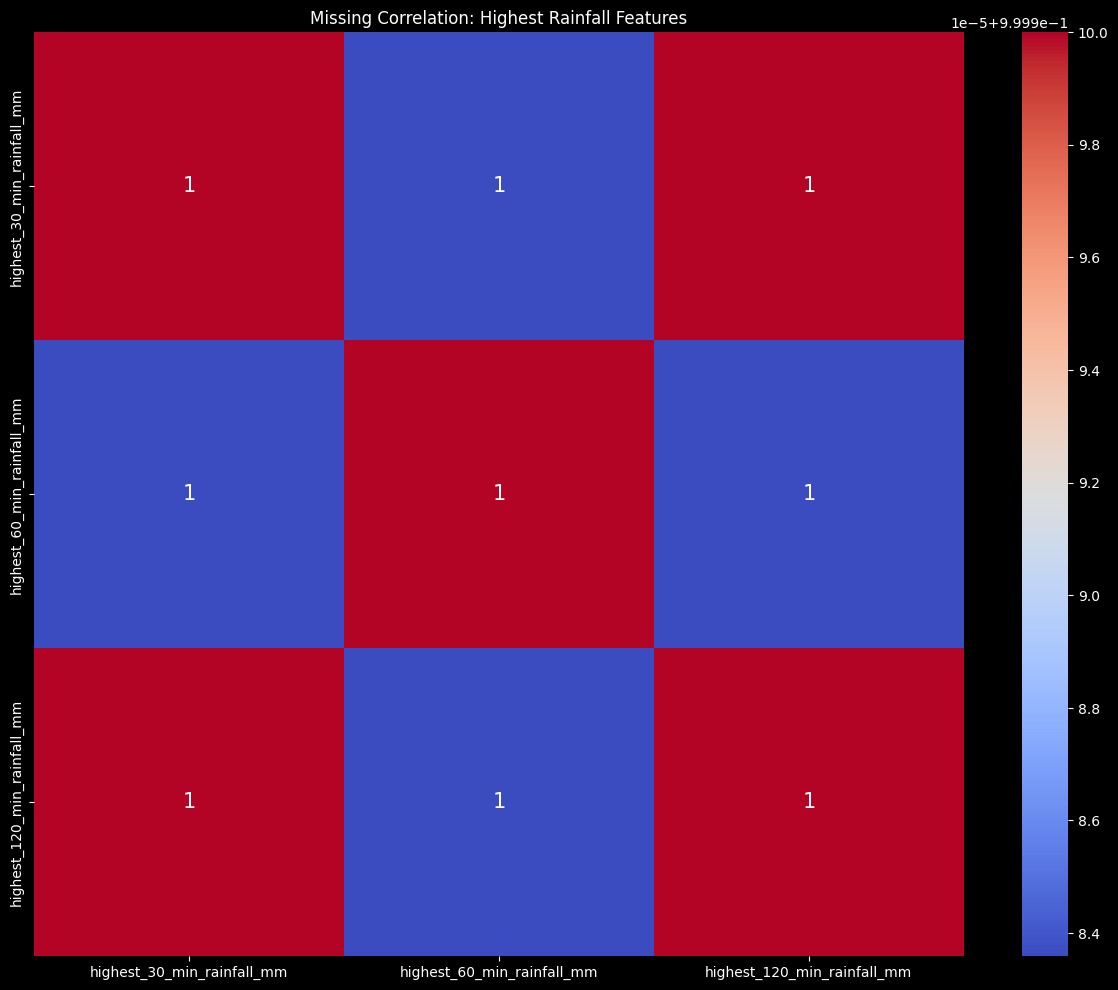

In [308]:
highest_cols = [
    'highest_30_min_rainfall_mm',
    'highest_60_min_rainfall_mm',
    'highest_120_min_rainfall_mm'
]

plt.figure(figsize=(15, 12))
sns.heatmap(
    train[highest_cols].isna().corr(),
    cmap='coolwarm',
    annot=True,
    annot_kws={'size':15}
)
plt.title("Missing Correlation: Highest Rainfall Features")
plt.show()

Therefore, our assumption is valid. We can impute 0 for those columns.

In [317]:
train[highest_cols] = train[highest_cols].fillna(0)
test[highest_cols] = test[highest_cols].fillna(0)

inspect_null()

                             Train missing  Test missing
daily_rainfall_total_mm                  0         22748
date                                     0             0
highest_120_min_rainfall_mm              0             0
highest_30_min_rainfall_mm               0             0
highest_60_min_rainfall_mm               0             0
location                                 0             0
max_wind_speed_kmh                  314818         14715
maximum_temperature_c               279266         13772
mean_temperature_c                  298552         13749
mean_wind_speed_kmh                 279862         14715
minimum_temperature_c               279313         13772


# **External Features**

In [125]:
dmi = pd.read_csv('../data/raw/Data Eksternal/Dipole Mode Index (DMI).csv')
aqi = pd.read_csv('../data/raw/Data Eksternal/AirQualityIndex_Google Trends.csv')
oni = pd.read_csv('../data/raw/Data Eksternal/OceanicNinoIndex (ONI).csv')
rh = pd.read_csv('../data/raw/Data Eksternal/RelativeHumidityMonthlyMean.csv')

print("DMI Shape :", dmi.shape)
print("AQI Shape :", aqi.shape)
print("ONI Shape :", oni.shape)
print("RH Shape  :", rh.shape)

DMI Shape : (1872, 2)
AQI Shape : (258, 2)
ONI Shape : (912, 2)
RH Shape  : (521, 2)


In [286]:
external_feature_datasets = {'dmi':dmi,
                             'aqi':aqi,
                             'oni':oni,
                             'rh':rh}

external_features = None

for idx, dataset in external_feature_datasets.items():
    dataset=dataset.copy()
    dataset.columns = ['external_date', f'feature_{idx}']

    dt_format=None
    if idx == 'oni':
        dt_format = '%d/%m/%Y' # Special format

    dataset['external_date'] = pd.to_datetime(dataset['external_date'], format=dt_format).dt.strftime("%Y-%m")
    dataset[f'feature_{idx}'].replace(-9999, np.nan, inplace=True)

    dataset[f'feature_{idx}'] = dataset[f'feature_{idx}'].ffill()

    for lag in [1, 2, 3, 6]:
        dataset[f'{idx}_lag_{lag}'] = dataset[f'feature_{idx}'].shift(lag)
    for window in [3, 6, 12]:
        dataset[f'{idx}_rolling_mean_{window}'] = dataset[f'feature_{idx}'].rolling(window, min_periods=1).mean()

    if external_features is None:
        external_features = dataset
    else:
        external_features = external_features.merge(
            dataset,
            on='external_date',
            how='right'
        )

external_features.external_date = pd.to_datetime(external_features.external_date)
external_features.tail()

,external_date,feature_dmi,dmi_lag_1,dmi_lag_2,dmi_lag_3,dmi_lag_6,dmi_rolling_mean_3,dmi_rolling_mean_6,dmi_rolling_mean_12,feature_aqi,...,oni_rolling_mean_6,oni_rolling_mean_12,feature_rh,rh_lag_1,rh_lag_2,rh_lag_3,rh_lag_6,rh_rolling_mean_3,rh_rolling_mean_6,rh_rolling_mean_12
516,2025-01-01,-0.196,-0.331,-0.383,-0.196,0.033,-0.303333,-0.120667,0.082667,0.0,...,-0.343333,0.154167,83.4,80.7,84.5,78.9,72.7,82.866667,80.366667,77.900000
517,2025-02-01,0.017,-0.196,-0.331,-0.383,0.267,-0.170000,-0.162333,0.056750,4.0,...,-0.388333,-0.000833,78.9,83.4,80.7,84.5,77.1,81.000000,80.666667,78.158333
518,2025-03-01,0.059,0.017,-0.196,-0.331,0.115,-0.040000,-0.171667,0.026583,0.0,...,-0.383333,-0.110833,82.4,78.9,83.4,80.7,77.6,81.566667,81.466667,78.841667
519,2025-04-01,0.149,0.059,0.017,-0.196,-0.196,0.075000,-0.114167,0.002333,0.0,...,-0.355000,-0.177500,81.3,82.4,78.9,83.4,78.9,80.866667,81.866667,79.316667
520,2025-05-01,0.149,0.149,0.059,0.017,-0.383,0.119000,-0.025500,-0.010000,4.0,...,-0.308333,-0.217500,79.2,81.3,82.4,78.9,84.5,80.966667,80.983333,79.441667


# **Merge External Features**

In [287]:
def merge_dataset(df, external_df, date_col):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], format = 'mixed')
    df['external_date'] = df[date_col].dt.strftime('%Y-%m')
    df['external_date'] = pd.to_datetime(df['external_date'])
    df = pd.merge(df, external_df, on = 'external_date', how = 'left')

    return df.drop(columns=['external_date'])

train_merged = merge_dataset(train, external_features, 'date')
test_merged = merge_dataset(test, external_features, 'date')

print('Train shape :', train_merged.shape)
print('Test shape  :', test_merged.shape)

Train shape : (416121, 43)
Test shape  : (22748, 43)


In [ ]:
def create_features(df):
    """
    Membuat fitur-fitur baru pada DataFrame cuaca.
    """
    # Salin DataFrame untuk menghindari SettingWithCopyWarning
    df = df.copy()

    # 1. Pastikan kolom 'date' dalam format datetime
    df['date'] = pd.to_datetime(df['date'])

    # --- 1. Ekstraksi Fitur Waktu ---
    print("Membuat fitur waktu...")
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)

    # --- 2. Rentang Temperatur Harian ---
    print("Membuat rentang temperatur harian...")
    df['temp_range_c'] = df['maximum_temperature_c'] - df['minimum_temperature_c']

    # --- 3. Faktor Hembusan Angin ---
    print("Membuat faktor hembusan angin...")
    # Ganti pembagian dengan nol atau NaN dengan 1 (menandakan angin stabil)
    df['wind_gust_factor'] = df['max_wind_speed_kmh'] / df['mean_wind_speed_kmh']
    df['wind_gust_factor'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df['wind_gust_factor'].fillna(1, inplace=True)

    # --- 4. Rasio Intensitas Hujan ---
    print("Membuat rasio intensitas hujan...")
    # Ganti pembagian dengan nol atau NaN dengan 1 (menandakan intensitas stabil)
    df['rain_intensity_ratio'] = df['highest_60_min_rainfall_mm'] / df['highest_30_min_rainfall_mm']
    df['rain_intensity_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df['rain_intensity_ratio'].fillna(1, inplace=True)

    # --- 5. Fitur Lag (Data 1 hari sebelumnya) ---
    print("Membuat fitur lag...")
    df = df.sort_values(by='date').reset_index(drop=True) # Pastikan data terurut sebelum membuat lag
    lag_features = ['mean_temperature_c', 'highest_60_min_rainfall_mm', 'mean_wind_speed_kmh']
    for feature in lag_features:
        df[f'{feature}_lag1'] = df[feature].shift(1)

    # --- 6. Statistik Bergulir (Rolling Statistics) ---
    print("Membuat statistik bergulir...")
    df['mean_temp_roll_7d'] = df['mean_temperature_c'].rolling(window=7, min_periods=1).mean()
    df['max_rain_roll_3d'] = df['highest_60_min_rainfall_mm'].rolling(window=3, min_periods=1).max()
    df['mean_wind_roll_7d'] = df['mean_wind_speed_kmh'].rolling(window=7, min_periods=1).mean()

    # --- FITUR SIKLUS & INTERAKSI AWAL ---
    days_in_year = 366
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / days_in_year)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / days_in_year)
    df['wind_x_rain'] = df['mean_wind_speed_kmh'] * df['highest_60_min_rainfall_mm']

    # --- FITUR BARU DARI DATA EKSTERNAL ---
    print("Menambahkan fitur interaksi dari data eksternal...")

    df['oni_x_temp'] = df['feature_oni'] * df['mean_temperature_c']
    df['dmi_x_rainfall'] = df['feature_dmi'] * df['highest_60_min_rainfall_mm']
    df['heat_index_proxy'] = df['feature_rh'] * df['mean_temperature_c']
    df['aqi_x_temp_range'] = df['feature_aqi'] * df['temp_range_c']
    print("-" * 30)
    return df

train_featured = create_features(train_merged)
test_featured = create_features(test_merged)

Membuat fitur waktu...
Membuat rentang temperatur harian...
Membuat faktor hembusan angin...
Membuat rasio intensitas hujan...
Membuat fitur lag...
Membuat statistik bergulir...
Menambahkan fitur interaksi dari data eksternal...
------------------------------
Membuat fitur waktu...
Membuat rentang temperatur harian...
Membuat faktor hembusan angin...
Membuat rasio intensitas hujan...
Membuat fitur lag...
Membuat statistik bergulir...
Menambahkan fitur interaksi dari data eksternal...
------------------------------


In [161]:
train_featured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416121 entries, 0 to 416120
Data columns (total 63 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             416121 non-null  datetime64[ns]
 1   highest_30_min_rainfall_mm       135603 non-null  float64       
 2   highest_60_min_rainfall_mm       135600 non-null  float64       
 3   highest_120_min_rainfall_mm      135603 non-null  float64       
 4   mean_temperature_c               117569 non-null  float64       
 5   maximum_temperature_c            136855 non-null  float64       
 6   minimum_temperature_c            136808 non-null  float64       
 7   mean_wind_speed_kmh              136259 non-null  float64       
 8   max_wind_speed_kmh               101303 non-null  float64       
 9   daily_rainfall_total_mm          416121 non-null  float64       
 10  location                         416121 non-

In [179]:
print('Train engineered shape :', train_featured.shape)
print('Test engineered shape  :', test_featured.shape)

train_featured.to_csv(CLEAN_PATH/'train_engineered.csv', index = False)
test_featured.to_csv(CLEAN_PATH/'test_engineered.csv', index = False)

Train engineered shape : (416121, 63)
Test engineered shape  : (22748, 63)
